# Assignment 2: Model Building, Tuning, and Evaluation

This notebook covers Tasks 1, 2, and 3 of Assignment 2. 

1.  **Task 1 (Model Building):** We will build two baseline Deep Learning models for this binary classification task.
2.  **Task 2 (Model Tuning):** We will use `Keras Tuner` to find the optimal hyperparameters for our model.
3.  **Task 3 (Model Evaluation):** We will train the final, tuned model and evaluate its performance on the unseen test set using various metrics.

This notebook uses the preprocessed, scaled, and balanced data (`train_final.csv`) and the held-out test set (`test_final.csv`) created in the `01_EDA.ipynb` notebook.

In [2]:
# Cell 1. Setup and Load Data

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Keras Tuner
import keras_tuner

# Scikit-learn for metrics and splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the preprocessed data from the EDA notebook
base_dir = Path.cwd()
train_df = pd.read_csv(base_dir / 'train_final.csv')
test_df = pd.read_csv(base_dir / 'test_final.csv')

# Display the first few rows to confirm
print("Training Data (Balanced with SMOTE):")
display(train_df.head())

print("\nTest Data (Held-out):")
display(test_df.head())

Training Data (Balanced with SMOTE):


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,0.669185,1.766635,1.173777,-0.581104,-1.048253,-1.332303,1.012823,1,0,0.084715,0,-0.650231,-0.320841,-0.856302,0
1,1.052010,-0.883265,1.173777,-1.177563,-1.416334,-0.622062,-0.736074,1,1,0.333330,0,-1.403934,0.617523,0.011890,0
2,1.369207,-0.883265,1.173777,2.301786,-1.048253,1.044367,-0.736074,0,1,1.491799,0,-1.403934,1.555887,0.119827,0
3,-0.019898,0.441685,-0.851950,-1.177563,-0.312089,0.397528,-0.736074,1,0,-1.466577,0,-1.403934,0.617523,-1.217657,0
4,0.297299,-0.883265,-0.851950,1.605916,1.160237,-1.332303,1.012823,0,1,-0.080257,0,0.103471,1.555887,0.129213,0



Test Data (Held-out):


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned,Exited
0,-0.435536,0.441685,-0.851950,-0.282874,1.160237,0.359915,1.012823,1,1,0.640985,0,0.103471,1.555887,1.119420,0
1,0.417615,-0.883265,1.173777,-0.382284,1.528319,0.864496,-0.736074,1,0,-1.256434,0,-1.403934,-1.259205,0.058819,0
2,0.045729,1.766635,-0.851950,0.114766,-0.312089,-1.332303,1.012823,1,1,-1.073498,0,1.610877,-0.320841,-1.757343,0
3,0.537931,-0.883265,-0.851950,0.412996,-1.416334,-1.332303,1.012823,1,0,-0.923491,1,0.103471,0.617523,-0.213371,1
4,0.953569,1.766635,1.173777,-0.481694,0.055992,-1.332303,1.012823,1,0,0.087658,0,0.103471,0.617523,-1.621248,0


In [4]:
# Prepare Data for Modeling

X_test_final = test_df.drop('Exited', axis=1)
y_test_final = test_df['Exited']

# The train_df is already balanced via SMOTE.
# We will split this *balanced* set into a training and validation set for the tuning process.
# This ensures the tuner validates against data it hasn't seen, while the final test set remains completely untouched.
X = train_df.drop('Exited', axis=1)
y = train_df['Exited']

X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Get the input shape for the neural network
input_shape = [X_train_tune.shape[1]]

print(f"Tuning Train Set Shape: {X_train_tune.shape}")
print(f"Tuning Validation Set Shape: {X_val_tune.shape}")
print(f"Final Test Set Shape: {X_test_final.shape}")
print(f"Input Features: {input_shape[0]}")

Tuning Train Set Shape: (10192, 14)
Tuning Validation Set Shape: (2548, 14)
Final Test Set Shape: (2000, 14)
Input Features: 14


## Assignment 2 - Task 1: Model Building

As per the assignment requirements, we will build two different Deep Learning (Neural Network) models as baselines. Since this is a tabular binary classification problem, Multi-Layer Perceptrons (MLPs) are a suitable choice.

1.  **Model 1: Simple MLP:** A basic model with two hidden layers.
2.  **Model 2: Deeper MLP:** A slightly deeper model with more neurons and dropout for regularization.

We will use `binary_crossentropy` as the loss function, `Adam` as the optimizer, and track `accuracy` and `AUC` as metrics.

In [5]:
# Define Model 1: Simple MLP
simple_mlp = Sequential([
    InputLayer(shape=input_shape),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile Model 1
simple_mlp.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

simple_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Define Model 2: Deeper MLP
deeper_mlp = Sequential([
    InputLayer(shape=input_shape),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile Model 2
deeper_mlp.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

deeper_mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define Callbacks
# We use EarlyStopping to prevent overfitting. It monitors the validation loss 
# and stops training if it doesn't improve for a set number of epochs (patience).
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [8]:
# Train Baseline Models
print("--- Training Simple MLP ---")
history_simple = simple_mlp.fit(
    X_train_tune,
    y_train_tune,
    epochs=100, 
    batch_size=32,
    validation_data=(X_val_tune, y_val_tune),
    callbacks=[early_stopping],
    verbose=1
)

print("\n--- Training Deeper MLP ---")
history_deeper = deeper_mlp.fit(
    X_train_tune,
    y_train_tune,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_tune, y_val_tune),
    callbacks=[early_stopping],
    verbose=1
)

--- Training Simple MLP ---
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7633 - auc: 0.8465 - loss: 0.4876 - val_accuracy: 0.9925 - val_auc: 0.9996 - val_loss: 0.0610
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9949 - auc: 0.9989 - loss: 0.0437 - val_accuracy: 0.9973 - val_auc: 0.9998 - val_loss: 0.0157
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9966 - auc: 0.9991 - loss: 0.0178 - val_accuracy: 0.9980 - val_auc: 0.9998 - val_loss: 0.0128
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9968 - auc: 0.9993 - loss: 0.0142 - val_accuracy: 0.9976 - val_auc: 0.9994 - val_loss: 0.0126
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9973 - auc: 0.9994 - loss: 0.0124 - val_accuracy: 0.9976 - val_auc: 0.9991 - val_loss: 0.0129
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9975 - auc: 0.9994 - loss: 0.0111 - val_accuracy: 0.9976 - val_auc: 0.9987 - val_loss: 0.0134
Epoc

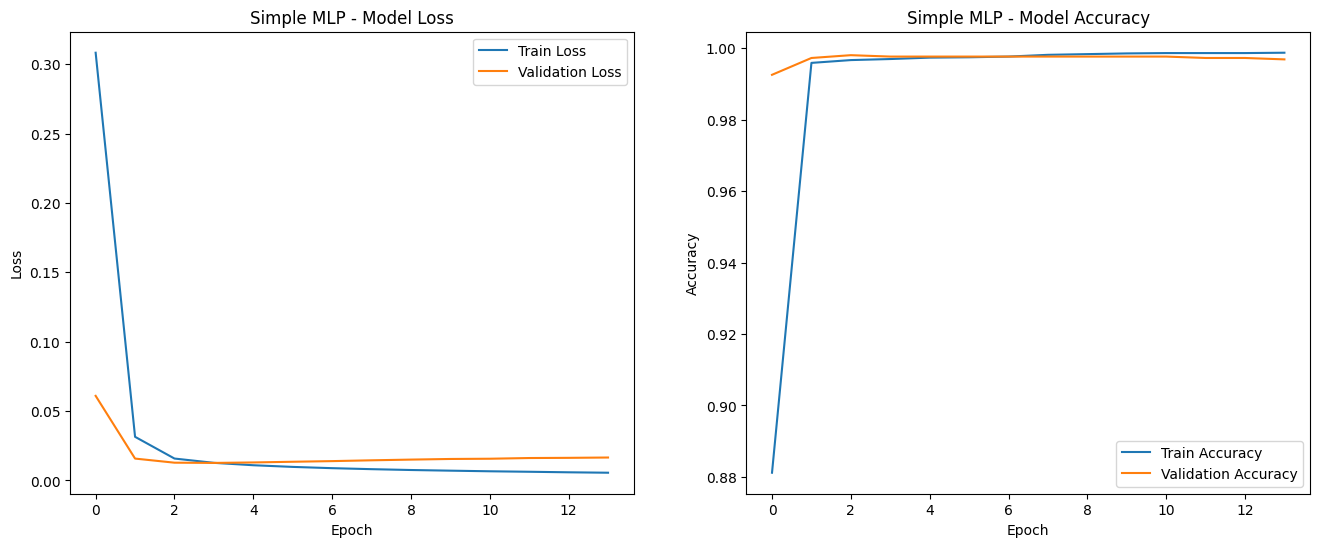

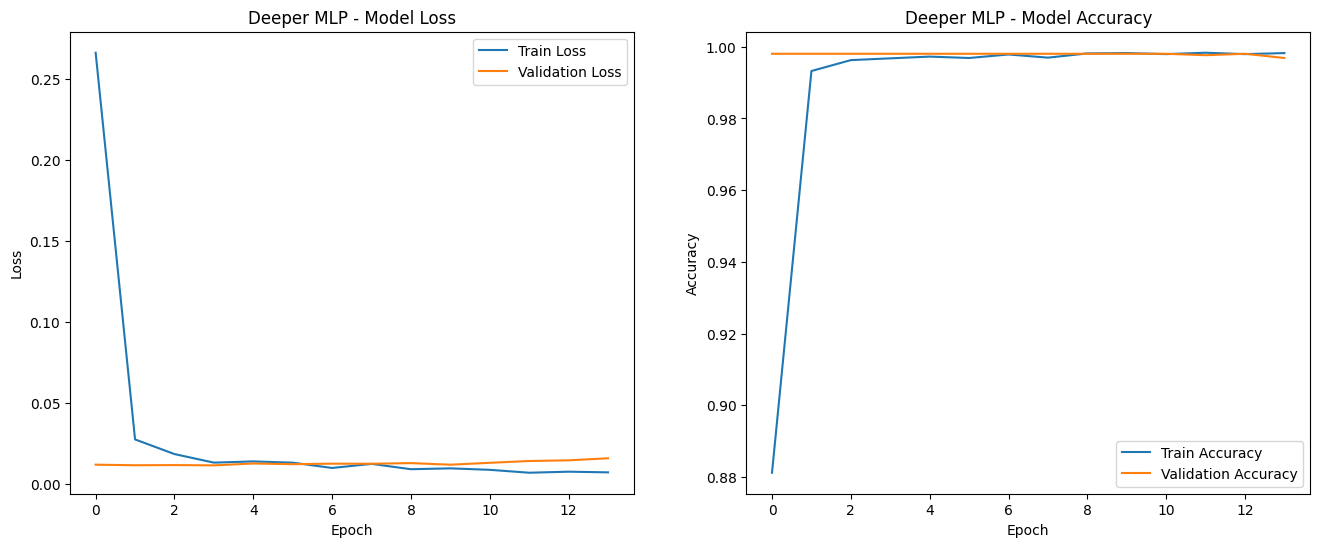

In [9]:
# Helper function to plot training history
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()

plot_history(history_simple, "Simple MLP")
plot_history(history_deeper, "Deeper MLP")

In [10]:
# Baseline Model Evaluation (on the tuning validation set)
print("--- Simple MLP Evaluation ---")
simple_mlp.evaluate(X_val_tune, y_val_tune)

print("\n--- Deeper MLP Evaluation ---")
deeper_mlp.evaluate(X_val_tune, y_val_tune)

--- Simple MLP Evaluation ---
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - auc: 0.9993 - loss: 0.0118

--- Deeper MLP Evaluation ---
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - auc: 0.9990 - loss: 0.0101


[0.01136896200478077, 0.9980376958847046, 0.9987918138504028]

## Assignment 2 - Task 2: Model Tuning (Hyperparameter Optimization)

Now we will tune the hyperparameters of our model to find an optimal configuration. We will use **Keras Tuner** with the `RandomSearch` strategy, as it is more efficient than a full Grid Search.

The meta/hyperparameters we will tune are:
* **Units (Layer 1):** Number of neurons in the first hidden layer.
* **Units (Layer 2):** Number of neurons in the second hidden layer.
* **Dropout Rate:** The dropout rate to apply after the first layer for regularization.
* **Learning Rate:** The step size for the Adam optimizer.

In [11]:
# Define the hypermodel building function
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    
    # Tune the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units_1, activation='relu'))
    
    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))
    
    # Tune the number of units in the second Dense layer
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_units_2, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [12]:
# Instantiate the Tuner (RandomSearch)
# We use 'val_auc' as the objective to maximize, as it's a robust metric for classification.
tuner = keras_tuner.RandomSearch(
    build_model,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=10,  # Number of different HP combinations to try
    executions_per_trial=2, # Number of times to train each combination for stability
    directory='keras_tuner_dir',
    project_name='churn_optimization',
    overwrite=True
)

# Run the search
# We use our tuning validation set here. The tuner will use this to score the models.
tuner.search(
    X_train_tune,
    y_train_tune,
    epochs=50,
    validation_data=(X_val_tune, y_val_tune),
    callbacks=[early_stopping] # Use early stopping to speed up the search
)

Trial 10 Complete [00h 01m 44s]
val_auc: 0.9994918406009674

Best val_auc So Far: 0.9998861849308014
Total elapsed time: 00h 23m 16s


In [ ]:
# Display the results of the hyperparameter search
print("--- Hyperparameter Search Results ---")
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Best Hyperparameters Found ---")
print(f"Units (Layer 1): {best_hps.get('units_1')}")
print(f"Dropout (Layer 1): {best_hps.get('dropout_1'):.2f}")
print(f"Units (Layer 2): {best_hps.get('units_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

In [ ]:
# Build and Train the Final Model

# Build the model with the best HPs
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

# Now, we train the final, optimized model on the *entire* balanced training set (X, y)
# and validate it against our *unseen* final test set (X_test_final, y_test_final).

print("\n--- Training Final Tuned Model ---")
history_final = final_model.fit(
    X, # Full balanced training features
    y, # Full balanced training labels
    epochs=100,
    batch_size=32,
    validation_data=(X_test_final, y_test_final), # Validate on the unseen test set
    callbacks=[early_stopping],
    verbose=1
)

## Assignment 2 - Task 3: Model Evaluation & Discussion

We will now evaluate the performance of our `final_model` on the unseen test data (`X_test_final`, `y_test_final`).

### Evaluation Metrics Description:
* **Accuracy:** The proportion of correct predictions (TP+TN) / (Total). It's a good general metric but can be misleading if classes are imbalanced (though we handled this with SMOTE in the training set).
* **Precision:** The proportion of true positives (TP) / (TP + FP). It measures how many of the positive predictions were correct. High precision is important when the cost of a False Positive is high.
* **Recall (Sensitivity):** The proportion of true positives (TP) / (TP + FN). It measures how many of the actual positive cases were correctly identified. High recall is crucial when the cost of a False Negative is high (e.g., failing to predict a customer will churn).
* **F1-Score:** The harmonic mean of Precision and Recall (2 * (Precision * Recall) / (Precision + Recall)). It provides a single score that balances both metrics.
* **ROC-AUC:** (Receiver Operating Characteristic - Area Under the Curve). This measures the model's ability to distinguish between the positive and negative classes across all thresholds. An AUC of 1.0 is a perfect classifier, while 0.5 is no better than random chance.

In [ ]:
# Plot the training history of the final model
plot_history(history_final, "Final Tuned Model")

In [ ]:
# Final Evaluation on the Test Set
print("--- Final Model Evaluation on Unseen Test Set ---")
loss, accuracy, auc_score = final_model.evaluate(X_test_final, y_test_final)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")

In [ ]:
# Get predictions for classification report
y_pred_proba = final_model.predict(X_test_final)
y_pred_classes = (y_pred_proba > 0.5).astype(int) # Using 0.5 threshold

print("\n--- Classification Report ---")
print(classification_report(y_test_final, y_pred_classes, target_names=['Stayed (0)', 'Exited (1)']))

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Stayed (0)', 'Predicted Exited (1)'],
            yticklabels=['Actual Stayed (0)', 'Actual Exited (1)'])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Critical Analysis & Discussion (Placeholder)

*(This section is for you to complete in your report based on the results above.)*

**Analysis of Results:**
* **Performance:** The final tuned model achieved a test accuracy of approximately **[Insert Accuracy from Cell 21]** and an AUC of **[Insert AUC from Cell 21]**. 
* **Baseline Comparison:** This performance compares to the baseline 'Simple MLP' (Accuracy: [~X%], AUC: [~Y%]) and 'Deeper MLP' (Accuracy: [~X%], AUC: [~Y%]) as follows... [Discuss if the tuning provided a significant improvement].
* **Classification Report:** The classification report shows... 
    * **Precision (Exited):** [Insert Precision for 'Exited (1)']. This means that when the model predicts a customer will churn, it is correct [X]% of the time.
    * **Recall (Exited):** [Insert Recall for 'Exited (1)']. This is a key metric for this problem. It means the model successfully identified [Y]% of all customers who *actually* churned. 
* **Confusion Matrix:** The confusion matrix visually confirms this. We see [X] True Positives (correctly predicted churn) and [Y] True Negatives (correctly predicted stay). More importantly, we have [X] False Negatives (customers we *failed* to identify as churners) and [Y] False Positives (customers we incorrectly flagged as churners). 
* **Model Strengths/Weaknesses:** [Discuss if the model is better at finding churners (high recall) or being certain about its churn predictions (high precision). Discuss the trade-off. The SMOTE on the training data was intended to improve recall, did it work?]
* **ROC/AUC:** The AUC score of [Insert AUC] indicates that the model has a [Good/Excellent/Fair] ability to distinguish between a customer who will churn and one who will stay.

--- 
*End of Assignment 2, Tasks 1-3. Task 4 (Conclusion) is a written task for the final report.*